In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-complaint-analysis/final_dataframe (1).csv
/kaggle/input/bank-customer-complaint-analysis/complaints.csv
/kaggle/input/bank-customer-complaint-analysis/Bank Customer Complaint Analysis for Efficient Dispute Resolution.ipynb
/kaggle/input/bank-customer-complaint-analysis/complaints_report_20240226_183305.txt


In [2]:
df = pd.read_csv('/kaggle/input/bank-customer-complaint-analysis/complaints.csv')

In [3]:
df = df.drop(['Unnamed: 0'], axis = 1)

In [4]:
df = df.drop_duplicates()

In [5]:
df = df.dropna()

In [6]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join(lemmatizer.lemmatize(word, pos='v') for word in text.split() if word not in stop_words)
    return text

df['narrative'] = df['narrative'].apply(clean_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
from sklearn.utils import resample

max_count = df['product'].value_counts().max()

dfs = []
for category in df['product'].unique():
    class_subset = df[df['product'] == category]
    class_upsampled = resample(class_subset,
                               replace=True,         
                               n_samples=max_count,  
                               random_state=42)
    dfs.append(class_upsampled)

df_balanced = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
df1 = df_balanced

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
le = LabelEncoder()
df1['product'] = le.fit_transform(df1['product'])

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional

In [25]:
X = df1['narrative'].values
y = df1['product'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = max(len(x) for x in X_train_seq)  
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [26]:
bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
bilstm_model.add(Bidirectional(LSTM(64)))
bilstm_model.add(Dense(16, activation='relu'))
bilstm_model.add(Dense(5, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [28]:
bilstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
history = bilstm_model.fit(X_train_pad, y_train, epochs=3, batch_size=64, validation_data=(X_test_pad, y_test))

Epoch 1/3


I0000 00:00:1749959684.332648     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


3519/3519 ━━━━━━━━━━━━━━━━━━━━ 632s 178ms/step - accuracy: 0.7119 - loss: 0.7983 - val_accuracy: 0.8429 - val_loss: 0.4933
Epoch 2/3
3519/3519 ━━━━━━━━━━━━━━━━━━━━ 625s 177ms/step - accuracy: 0.8622 - loss: 0.4235 - val_accuracy: 0.8830 - val_loss: 0.3634
Epoch 3/3
3519/3519 ━━━━━━━━━━━━━━━━━━━━ 625s 177ms/step - accuracy: 0.8989 - loss: 0.3098 - val_accuracy: 0.9006 - val_loss: 0.3130


In [31]:
import matplotlib.pyplot as plt

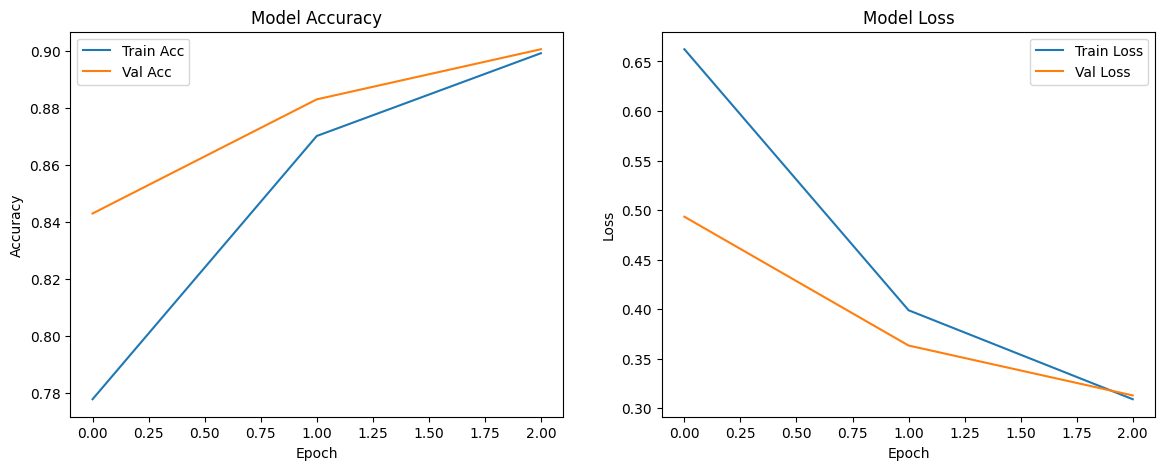

In [32]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [33]:
y_pred_prob = bilstm_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)

1760/1760 ━━━━━━━━━━━━━━━━━━━━ 100s 56ms/step


In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [37]:
import seaborn as sns

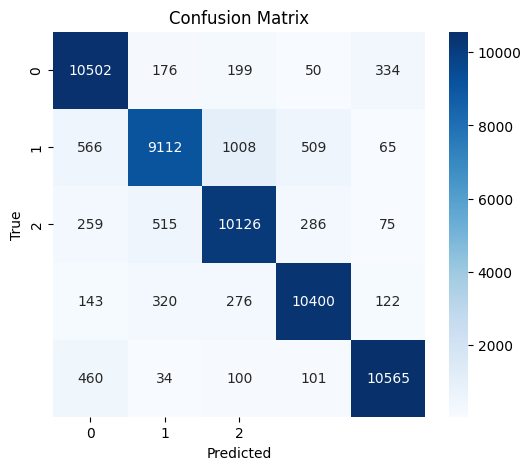

In [38]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [39]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

Classification Report:

              precision    recall  f1-score   support

           0     0.8803    0.9326    0.9057     11261
           1     0.8971    0.8092    0.8509     11260
           2     0.8648    0.8992    0.8817     11261
           3     0.9166    0.9235    0.9201     11261
           4     0.9466    0.9383    0.9424     11260

    accuracy                         0.9006     56303
   macro avg     0.9011    0.9006    0.9002     56303
weighted avg     0.9011    0.9006    0.9002     56303



In [40]:
bilstm_model.save('bilstm_model.h5')